# Tutorial 1: Basics


In this tutorial you will learn how to:
* run LightAutoML training on tabular data
* obtain feature importances and reports
* configure resource usage in LightAutoML

Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML)

<img src="https://github.com/sberbank-ai-lab/LightAutoML/blob/master/imgs/LightAutoML_logo_big.png?raw=1" alt="LightAutoML logo" style="width:100%;"/>

## 0. Prerequisites

### 0.0. install LightAutoML

In [1]:
# !pip install -U lightautoml

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [2]:
# Standard python libraries
import os
import time
import joblib

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

from utils import score_model

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [3]:
N_THREADS = 10
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'DSHORTT1138P2300058'

In [4]:
DATASET_DIR = 'data/'
DATASET_NAME = 'clean_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
# DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/examples/data/sampled_app_train.csv'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [6]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [7]:
data = pd.read_csv(DATASET_FULLNAME)
data.drop(['Unnamed: 0', 'UUID', 'UNIXDT'], axis=1, inplace=True)
data.head()

,WELL_ID,DT,T1138P6000096,T1138P6000315,DMIDT1138P4000064,DSHORTT1138P4000064,DLONGT1138P4000064,DMIDT1138P2600012,DSHORTT1138P2600012,DLONGT1138P2600012,DMIDT1205P2300000,DSHORTT1205P2300000,DLONGT1205P2300000,T1205P2300000,T1138P4000064,T1138P2600012,T1138P600050,T1013P500399,DSHORTT1138P2300058
0,226003330,2019-07-31 23:55:00,300,0,-2.150755,0.0,-2.290611,-0.279070,0.0,-0.313752,-0.001102,0.000587,-0.000245,1.168133,70,19.6,0.759,NaN,-0.1344
1,226003330,2019-07-31 23:50:00,0,0,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.167644,70,19.6,0.761,NaN,0.0000
2,226003330,2019-07-31 23:45:00,0,28500,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.161290,0,0.0,0.000,NaN,0.0000
3,226003330,2019-07-31 23:40:00,0,28200,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.160802,0,0.0,0.000,NaN,0.0000
4,226003330,2019-07-31 23:35:00,0,27900,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,-0.001172,0.000000,-0.000251,1.162268,0,0.0,0.000,NaN,0.0000


In [8]:
data = data.fillna(0)

In [9]:
to_shift = ['T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058']

In [10]:
for var in to_shift:
    data[var + '_l1'] = data.sort_values(['WELL_ID', 'DT']).groupby('WELL_ID', group_keys=False)[var].shift()
    data[var + '_l2'] = data.sort_values(['WELL_ID', 'DT']).groupby('WELL_ID', group_keys=False)[var].shift(2)

In [11]:
data = data.dropna()

In [12]:
data

,WELL_ID,DT,T1138P6000096,T1138P6000315,DMIDT1138P4000064,DSHORTT1138P4000064,DLONGT1138P4000064,DMIDT1138P2600012,DSHORTT1138P2600012,DLONGT1138P2600012,...,T1138P4000064_l1,T1138P4000064_l2,T1138P2600012_l1,T1138P2600012_l2,T1138P600050_l1,T1138P600050_l2,T1013P500399_l1,T1013P500399_l2,DSHORTT1138P2300058_l1,DSHORTT1138P2300058_l2
0,226003330,2019-07-31 23:55:00,300,0,-2.150755,0.0,-2.290611,-0.279070,0.0,-0.313752,...,70.0,0.0,19.6,0.0,0.761,0.0,0.0,0.0,0.0,0.0
1,226003330,2019-07-31 23:50:00,0,0,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2,226003330,2019-07-31 23:45:00,0,28500,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
3,226003330,2019-07-31 23:40:00,0,28200,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
4,226003330,2019-07-31 23:35:00,0,27900,-2.172480,0.0,-2.292904,-0.281889,0.0,-0.314066,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160255,226000188,2019-06-27 07:10:00,0,15000,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
160256,226000188,2019-06-27 07:05:00,0,14700,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
160257,226000188,2019-06-27 07:00:00,0,14400,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
160258,226000188,2019-06-27 06:55:00,0,14100,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0


In [13]:
data.isnull().sum(axis = 0)

WELL_ID                   0
DT                        0
T1138P6000096             0
T1138P6000315             0
DMIDT1138P4000064         0
DSHORTT1138P4000064       0
DLONGT1138P4000064        0
DMIDT1138P2600012         0
DSHORTT1138P2600012       0
DLONGT1138P2600012        0
DMIDT1205P2300000         0
DSHORTT1205P2300000       0
DLONGT1205P2300000        0
T1205P2300000             0
T1138P4000064             0
T1138P2600012             0
T1138P600050              0
T1013P500399              0
DSHORTT1138P2300058       0
T1138P6000096_l1          0
T1138P6000096_l2          0
T1138P6000315_l1          0
T1138P6000315_l2          0
DMIDT1138P4000064_l1      0
DMIDT1138P4000064_l2      0
DSHORTT1138P4000064_l1    0
DSHORTT1138P4000064_l2    0
DLONGT1138P4000064_l1     0
DLONGT1138P4000064_l2     0
DMIDT1138P2600012_l1      0
DMIDT1138P2600012_l2      0
DSHORTT1138P2600012_l1    0
DSHORTT1138P2600012_l2    0
DLONGT1138P2600012_l1     0
DLONGT1138P2600012_l2     0
DMIDT1205P2300000_l1

### 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [14]:
# tr_data, te_data = train_test_split(
#     data, 
#     test_size=TEST_SIZE, 
#     stratify=data['WELL_ID'], 
#     random_state=RANDOM_STATE
# )
p = 100 * TEST_SIZE
te_data = data.sort_values(['WELL_ID', 'DT'])\
        .groupby('WELL_ID', group_keys=False)\
        .apply(lambda x: x.tail(int(len(x) * (p / 100))))

tr_data = data.sort_values(['WELL_ID', 'DT'])\
        .groupby('WELL_ID', group_keys=False)\
        .apply(lambda x: x.head(int(len(x) * (1-TEST_SIZE))))

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (128178, 53), te_data = (32040, 53)


,WELL_ID,DT,T1138P6000096,T1138P6000315,DMIDT1138P4000064,DSHORTT1138P4000064,DLONGT1138P4000064,DMIDT1138P2600012,DSHORTT1138P2600012,DLONGT1138P2600012,...,T1138P4000064_l1,T1138P4000064_l2,T1138P2600012_l1,T1138P2600012_l2,T1138P600050_l1,T1138P600050_l2,T1013P500399_l1,T1013P500399_l2,DSHORTT1138P2300058_l1,DSHORTT1138P2300058_l2
160259,226000188,2019-06-27 06:50:00,0,13800,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160258,226000188,2019-06-27 06:55:00,0,14100,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160257,226000188,2019-06-27 07:00:00,0,14400,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160256,226000188,2019-06-27 07:05:00,0,14700,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160255,226000188,2019-06-27 07:10:00,0,15000,-3.232999,0.0,-4.138484,-0.423734,0.0,-0.656976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [16]:
task = Task('reg', metric='mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [17]:
roles = {
    'target': TARGET_NAME,
    'drop': ['DT']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/sberbank-ai-lab/LightAutoML/blob/master/imgs/tutorial_blackbox_pipeline.png?raw=1" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [18]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [19]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[22:04:28] Stdout logging level is INFO.
[22:04:28] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[22:04:28] Task: reg

[22:04:28] Start automl preset with listed constraints:
[22:04:28] - time: 300.00 seconds
[22:04:28] - CPU: 10 cores
[22:04:28] - memory: 16 GB

[22:04:28] Train data shape: (128178, 53)

[22:04:37] Layer 1 train process start. Time left 291.56 secs
[22:04:54] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:05:02] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.013173797465407235
[22:05:02] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:05:02] Time left 266.22 secs

[22:05:13] Selector_LightGBM fitting and predicting completed
[22:05:31] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:06:01] Time limit exceeded after calculating fold 1

[22:06:01] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.005011475213678643
[22:06:01] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting co

# 3. Prediction on holdout and model evaluation

<AxesSubplot:>

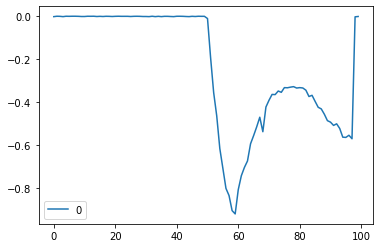

In [20]:
pd.DataFrame(oof_pred.data[:, 0])[:100].plot()

In [21]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[-0.3683881 ],
       [-0.372952  ],
       [-0.39375272],
       ...,
       [-0.08153489],
       [-0.0865075 ],
       [-0.20729008]], dtype=float32)
Shape = (32040, 1)
Wall time: 3.56 s


<AxesSubplot:>

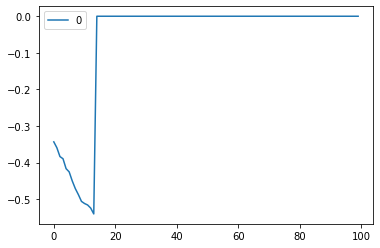

In [22]:
pd.DataFrame(te_data[TARGET_NAME].values)[:100].plot()

In [23]:
te_data[TARGET_NAME].values

array([-0.34325469, -0.35932922, -0.3833963 , ...,  0.        ,
        0.        , -0.1344    ])

In [25]:
oof_pred.data[:, 0]

array([-1.7294346e-03,  7.6344659e-05, -3.0681083e-04, ...,
       -6.3316065e-01, -6.3422537e-01, -6.3428950e-01], dtype=float32)

In [26]:
sum(~np.isnan(oof_pred.data[:, 0]))

128178

In [27]:
print(f'OOF score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')


OOF score: 0.005306626303904423
HOLDOUT score: 0.06787788723218796


<AxesSubplot:>

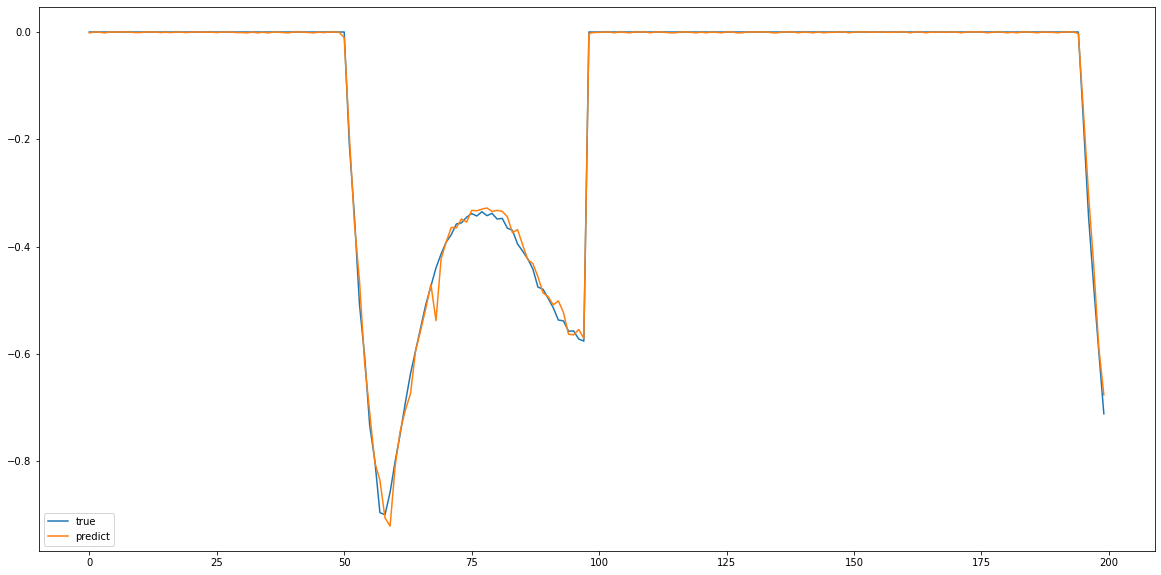

In [28]:
pd.DataFrame({'true':tr_data[TARGET_NAME].values, 'predict':oof_pred.data[:, 0]})[0:200].plot(figsize=(20,10))

<AxesSubplot:>

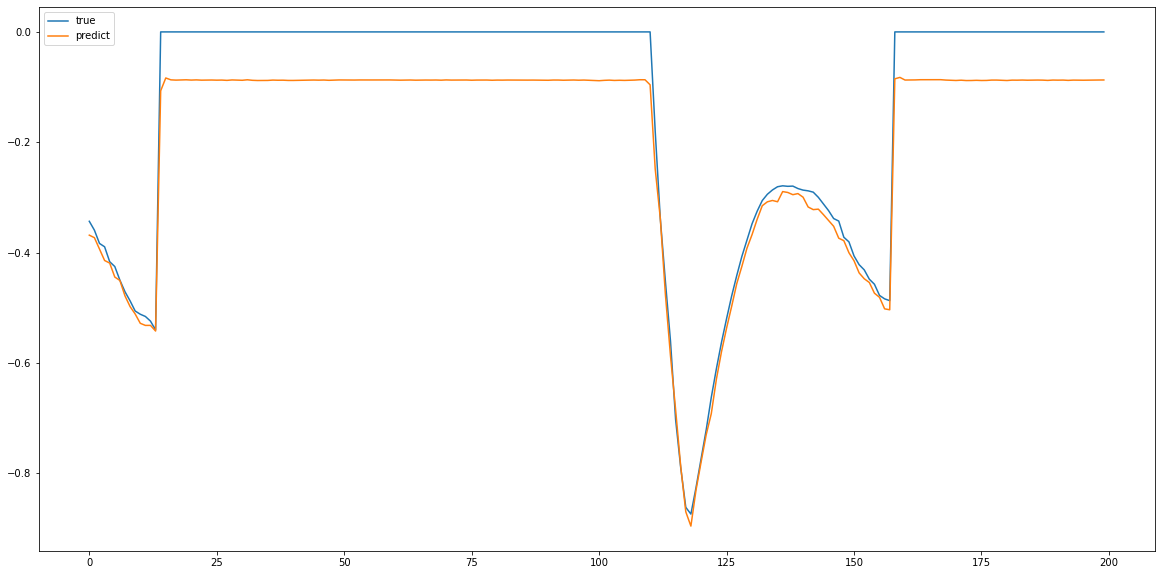

In [29]:
pd.DataFrame({'true':te_data[TARGET_NAME].values, 'predict':te_pred.data[:, 0]})[0:200].plot(figsize=(20,10))

# 4. Model analysis

## 4.1. Reports

You can obtain the description of the resulting pipeline:

In [30]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.51708 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.35134 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.13158 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


Also for this purposes LightAutoML have ReportDeco, use it to build reports:

In [31]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [32]:
%%time
oof_pred = automl_rd.fit_predict(tr_data, roles = roles, verbose = 1)

[22:08:18] Stdout logging level is INFO.
[22:08:18] Task: reg

[22:08:18] Start automl preset with listed constraints:
[22:08:18] - time: 300.00 seconds
[22:08:18] - CPU: 10 cores
[22:08:18] - memory: 16 GB

[22:08:18] Train data shape: (128178, 53)

[22:08:22] Layer 1 train process start. Time left 296.40 secs
[22:08:39] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:08:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.013199846917968132
[22:08:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:08:47] Time left 270.94 secs

[22:08:59] Selector_LightGBM fitting and predicting completed
[22:09:16] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:09:46] Time limit exceeded after calculating fold 1

[22:09:46] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.005011475213678643
[22:09:46] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:09:46] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is

So the report is available in tabularAutoML_model_report folder

In [33]:
!ls tabularAutoML_model_report

feature_importance.png
lama_interactive_report.html
valid_error_hist.png
valid_scatter_plot.png
valid_target_distribution.png


In [34]:
%%time

te_pred = automl_rd.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[-0.3683881 ],
       [-0.372952  ],
       [-0.39375272],
       ...,
       [-0.08153489],
       [-0.0865075 ],
       [-0.20729008]], dtype=float32)
Shape = (32040, 1)
Wall time: 14.6 s


In [35]:
print(f'OOF score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.005306626303904423
HOLDOUT score: 0.06787788723218796


## 4.2 Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

Wall time: 145 ms


<AxesSubplot:xlabel='Feature'>

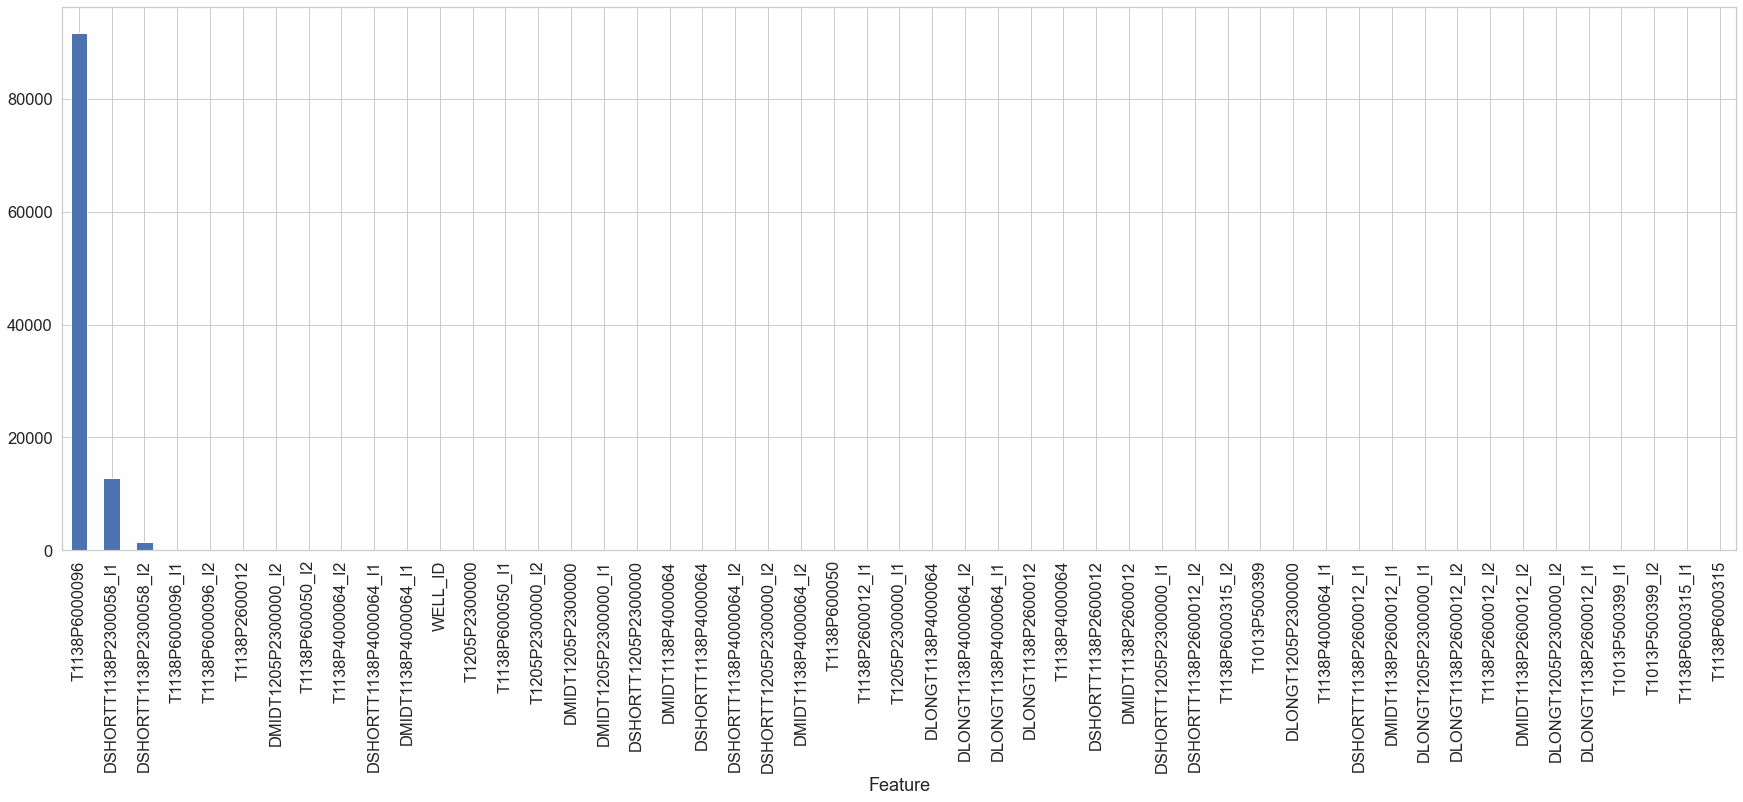

In [36]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [37]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent = False)

Wall time: 3min


<AxesSubplot:xlabel='Feature'>

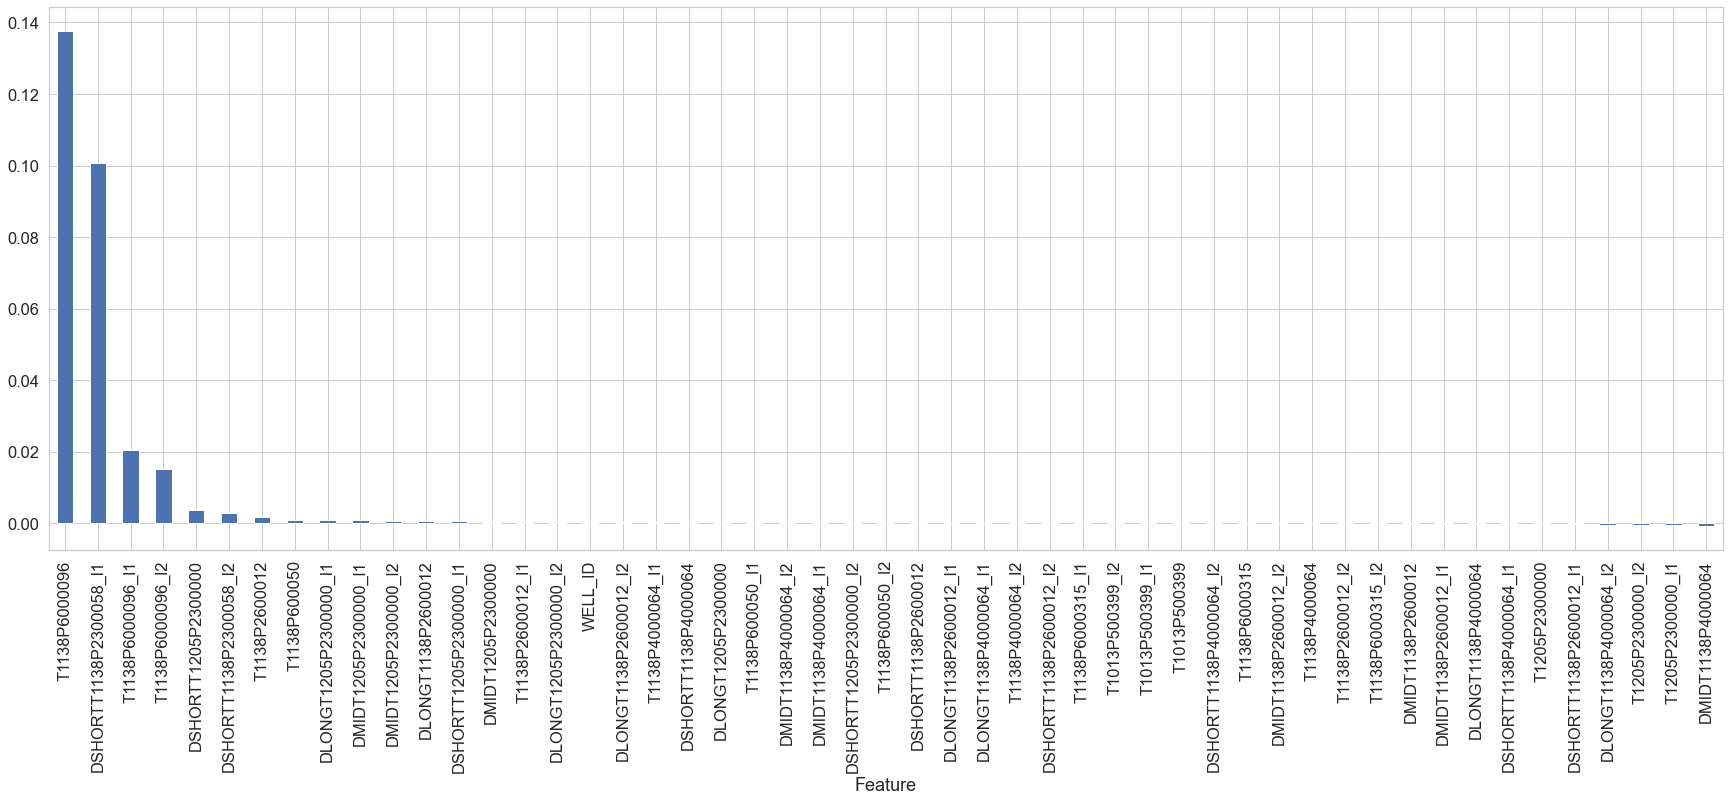

In [38]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

## Bonus: where is the automatic report?

As we used `automl_rd` in our training and prediction cells, it is already ready in the folder we specified - you can check the output kaggle folder and find the `tabularAutoML_model_report` folder with `lama_interactive_report.html` report inside (or just [click this link](tabularAutoML_model_report/lama_interactive_report.html) for short). It's interactive so you can click the black triangles on the left of the texts to go deeper in selected part.

# 5. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage

Using `TabularAutoML` we spent only 31 second to build the model with setup `TIMEOUT` equal to 5 minutes. To spend (almost) all the `TIMEOUT` we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API:

In [39]:
utilized_automl = TabularUtilizedAutoML(
    task = task, 
    timeout = 1000,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [40]:
%%time 

oof_pred = utilized_automl.fit_predict(tr_data, roles = roles, verbose = 1)

[22:21:08] Start automl utilizator with listed constraints:
[22:21:08] - time: 1000.00 seconds
[22:21:08] - CPU: 10 cores
[22:21:08] - memory: 16 GB

[22:21:08] If one preset completes earlier, next preset configuration will be started

[22:21:08] ==================================================
[22:21:08] Start 0 automl preset configuration:
[22:21:08] C:\Users\ksetd\Anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[22:21:08] Stdout logging level is INFO.
[22:21:08] Task: reg

[22:21:08] Start automl preset with listed constraints:
[22:21:08] - time: 1000.00 seconds
[22:21:08] - CPU: 10 cores
[22:21:08] - memory: 16 GB

[22:21:08] Train data shape: (128178, 53)

[22:21:16] Layer 1 train process start. Time left 991.77 secs
[22:21:33] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:21:44] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished

In [41]:
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[-1.6867809e-03],
       [-8.0561716e-05],
       [-1.4156931e-04],
       ...,
       [-6.3013262e-01],
       [-6.3286370e-01],
       [-6.3232529e-01]], dtype=float32)
Shape = (128178, 1)


In [42]:
print(utilized_automl.create_model_str_desc())

Final prediction for new objects = 
	1.00000 * 1 averaged models with config = "C:\Users\ksetd\Anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.19688 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.68274 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.06019 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.06019 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 





Prediction on holdout and metric calculation

In [43]:
%%time

te_pred = utilized_automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[-0.36337703],
       [-0.36964756],
       [-0.3872084 ],
       ...,
       [-0.06159497],
       [-0.06207047],
       [-0.19453265]], dtype=float32)
Shape = (32040, 1)
Wall time: 5.22 s


In [44]:
print(f'OOF score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.004261035205414544
HOLDOUT score: 0.053019963219843126


# predict on  valid 1 and 2

In [13]:
def read_valid(link = DATASET_FULLNAME):
    data = pd.read_csv(link)
    data.drop(['Unnamed: 0', 'UUID', 'UNIXDT'], axis=1, inplace=True)
    data.drop(['DLONGT1138P2300058',
 'DMIDT1138P2300058',
 'LONGUPT1138P2300058',
 'MIDUPT1138P2300058',
 'SHORTUPT1138P2300058'], axis=1, inplace=True, errors='ignore')
    data = data.fillna(0)
    to_shift = ['T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058']
    for var in to_shift:
        data[var + '_l1'] = data.sort_values(['WELL_ID', 'DT']).groupby('WELL_ID', group_keys=False)[var].shift()
        data[var + '_l2'] = data.sort_values(['WELL_ID', 'DT']).groupby('WELL_ID', group_keys=False)[var].shift(2)
    data = data.fillna(0)
    data = data.sort_values(['WELL_ID', 'DT'])
    return data

In [14]:
valid1 = 'data/cfp_dataset_v1_valid1.csv'
valid2 = 'data/cfp_dataset_v1_valid2.csv'

In [15]:
validdata1 = read_valid(valid1)
validdata2 = read_valid(valid2)

In [17]:
pred_valid1 = utilized_automl.predict(validdata1)
pred_valid2 = utilized_automl.predict(validdata2)


In [18]:
Lama_prediction = {'Valid1':{'true':validdata1[TARGET_NAME].values, 
                             'prediction':pred_valid1.data[:, 0]},
                   'Valid2':{'true':validdata2[TARGET_NAME].values, 
                             'prediction':pred_valid2.data[:, 0]}}

In [29]:
automl_validation_results = score_model(Lama_prediction)
automl_validation_results.loc['mean_auto_ml_valid'] = automl_validation_results.mean()
automl_validation_results

,mape,smape,mae,r2_value
Valid1,2.174450e+14,1.528292,0.053008,0.955129
Valid2,2.171193e+14,1.518272,0.055530,0.949158
mean_auto_ml_valid,2.172822e+14,1.523282,0.054269,0.952144


In [30]:
automl_validation_results.to_csv('automl_validation_results.csv', sep=';', decimal=',', index=True)


<AxesSubplot:>

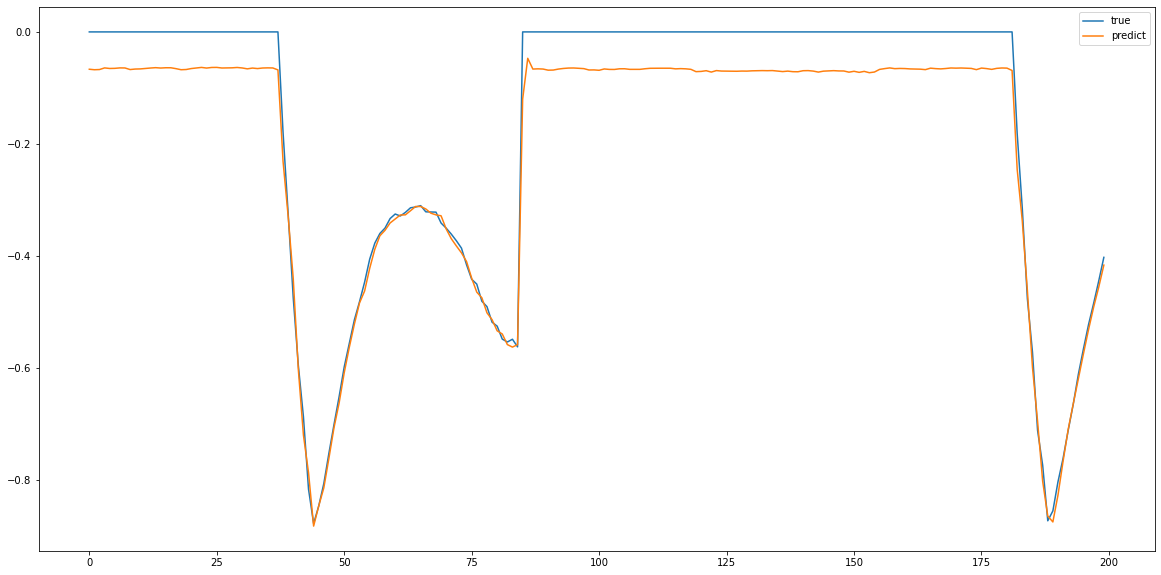

In [21]:
pd.DataFrame({'true':validdata1[TARGET_NAME].values, 'predict':pred_valid1.data[:, 0]})[0:200].plot(figsize=(20,10))

<AxesSubplot:>

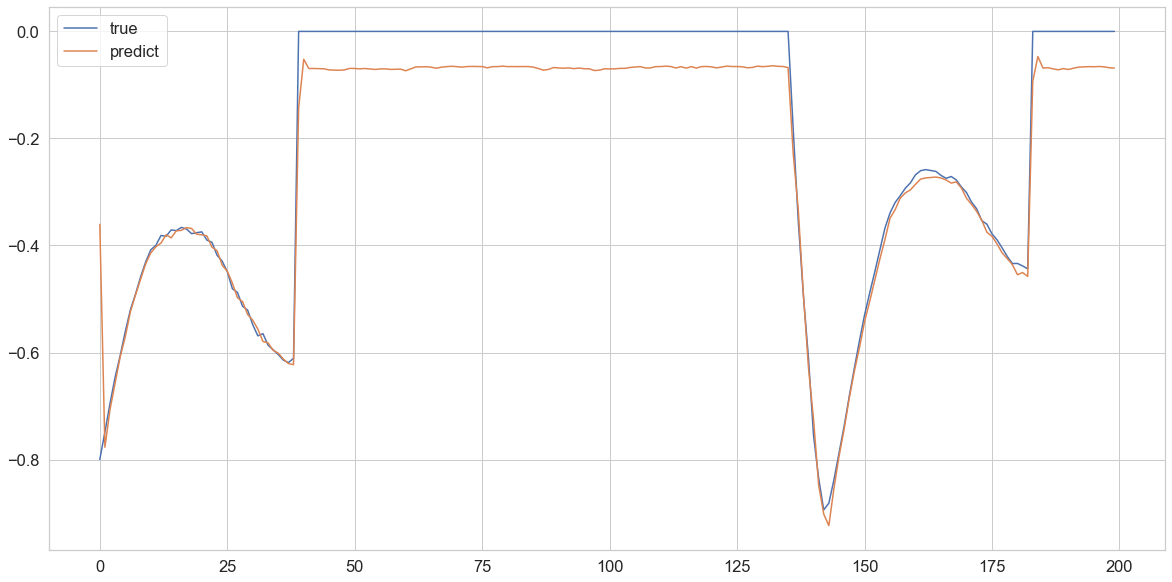

In [51]:
pd.DataFrame({'true':validdata2[TARGET_NAME].values, 'predict':pred_valid2.data[:, 0]})[0:200].plot(figsize=(20,10))

In [52]:
joblib.dump(utilized_automl, 'utilized_automl_model.pkl')

In [16]:
utilized_automl=joblib.load('utilized_automl_model.pkl')

# Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)